## Install & import *requirements*, Workspace configuration

Install all requirements needed

In [ ]:
!pip install torch==1.4.0 nlp==0.3.0 pyarrow==0.16.0 transformers==3.0.2 scikit-learn==0.22.2 numpy==1.18.2 tqdm==4.43.0 six==1.15.0 tabulate==0.8.7 pkbar==0.4 nltk==3.2.5 tabulate==0.8.7
exit()  # to restart the kernel

Imports

In [ ]:
import json
import os
import pickle
import datetime
import random
import numpy as np
from pathlib import Path
import logging
import importlib
import warnings
import time

import nlp
import nltk
import torch
from tabulate import tabulate
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader
from tqdm.autonotebook import tqdm

import torch.nn as nn
from torch.nn.modules.module import _addindent
from nltk.tokenize import RegexpTokenizer 

from torch.nn.utils import clip_grad_norm_
from torch.optim.lr_scheduler import ReduceLROnPlateau
from transformers import (AutoTokenizer, AutoModel,
                          AdamW, get_linear_schedule_with_warmup,
                          get_cosine_schedule_with_warmup)

import pkbar
import shutil

- Configure workspace
    1. Ignore warnings 
    2. Fix seed
    3. Download nltk needed packages
    4. Configure logger
    5. Create & Remove folders

- Utilites 
    1. save & load pickles
    2. Ensure directory existing, create if not existing

In [ ]:
def manage_workspace_directories():
    dir_path = os.getcwd()
    folders = ['model', 'runs']
    folders_to_remove = ['sample_data']

    for folder in folders:
        if not os.path.exists(folder):
            os.mkdir(os.path.join(dir_path, folder))
    
    for folder in folders_to_remove:
        if os.path.exists(folder):
            shutil.rmtree(folder)


def configure_workspace(SEED=1873337):
    """
    Configure seed for reproducability, configure logging messages
    """
    warnings.filterwarnings("ignore")
    random.seed(SEED)
    np.random.seed(SEED)
    os.environ['PYTHONHASHSEED'] = str(SEED)
    torch.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    nltk.download('punkt', quiet=True)
    logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s",
                        datefmt='%H:%M:%S', level=logging.WARNING)
    manage_workspace_directories()


def save_pickle(save_to, save_what):
    """ Save data into pickle format"""
    with open(save_to, mode='wb') as f:
        pickle.dump(save_what, f)


def load_pickle(load_from):
    """ Load data from presaved pickle file"""
    with open(load_from, 'rb') as f:
        return pickle.load(f)


def ensure_dir(path):
    """
    Makes sure direcctory exists and if not it creates it
    """
    if not os.path.exists(path):
        os.makedirs(path)

## Dataset Parser

- Create data parser object inherting from `torch.utils.data.Dataset`
    - Creates labels vocabulary
    - load Pretrained language model tokenizer `AutoTokenizer.from_pretrained('xlm-roberta-large')`
    - Encode dataset using `encode_plus()` pass to it a premise to be paired with a hypothesis as NLI is a sequence-pair classification
    - Pad sequences as per batch (not used) as sequences are padded/trimmed per batch
    - Decode predictions  

In [ ]:
class PTMDatasetParser(Dataset):
    """
    XLMRDatasetParser identical to XLMRDatasetParser but without passing to the model the languages sequences
    it builds the label2idx and idx2label, uses XLM Tokenizer, lowers all tokens,
    indexes the dataset and pads per batch to feed model sequences of the same length
    """

    def __init__(self, _device, data_, model_="xlm-roberta-large"):
        super(PTMDatasetParser).__init__()
        self.encoded_data = []
        self.device = _device
        self.languages, self.premises, self.hypotheses, self.labels = data_
        self.model_name = model_
        self.label2idx = {'entailment': 0, 'neutral': 1, 'contradiction': 2}
        self.idx2label = {0: 'entailment', 1: 'neutral', 2: 'contradiction'}

    def __len__(self):
        return len(self.premises)

    def __getitem__(self, idx):
        if self.encoded_data is None:
            raise RuntimeError("Dataset is not indexed yet.\
                                To fetch raw elements, use get_element(idx)")
        return self.encoded_data[idx]

    def get_element(self, idx):
        return self.languages[idx], self.premises[idx], self.hypotheses[idx], self.labels[idx]

    def encode_dataset(self):
        """ Indexing and encoding the dataset using XLMTokenizer whilst lowering all tokens
        Tokenizer takes the sentence A (premises) and sentence B (hypotheses) adds to them the special tokens
        [CLS] & [SEP], it pads sentences to max length of 128 and truncates the ones with lengthier number of tokens
            - Original Sequence (inputs_ids) is changed to its corresponding IDs
            - Attention masks helps the model differntiate between [PAD] and original tokens
            - Token types helps the model know which sentence is Sentence A and which is the sentence B
        """

        tokenizer = AutoTokenizer.from_pretrained(self.model_name, do_lower_case=True)
        for lang_, premise_, hypothesis_, labels_ in tqdm(
                zip(self.languages, self.premises, self.hypotheses, self.labels),
                leave=False, total=len(self.premises),
                desc=f'Encoding dataset'):
            encoded_dict = tokenizer.encode_plus(text=premise_,
                                                 text_pair=hypothesis_,
                                                 add_special_tokens=True,
                                                 return_token_type_ids=True,
                                                 return_attention_mask=True,
                                                 max_length=128,
                                                 truncation=True,
                                                 pad_to_max_length=True,
                                                 return_tensors='pt')
            self.encoded_data.append({'premises_hypotheses': torch.squeeze(encoded_dict["input_ids"]),
                                      'attention_mask': torch.squeeze(encoded_dict["attention_mask"]),
                                      'token_types': torch.squeeze(encoded_dict["token_type_ids"]),
                                      'outputs': torch.LongTensor([self.label2idx.get(labels_)])})

    @staticmethod
    def pad_batch(batch):
        """ Pads sequences per batch with `padding_value=0`
        Args: batch: List[dict]
        Returns: dict of models inputs padded as per max len in batch
        """
        # XLM-R tokenizer padding index is 2, hence it is the padding value in `padded_premises_hypotheses`
        premises_hypotheses_batch = [sample["premises_hypotheses"] for sample in batch]
        padded_premises_hypotheses = pad_sequence(premises_hypotheses_batch, padding_value=2, batch_first=True)
        mask = [sample["attention_mask"] for sample in batch]
        padded_mask = pad_sequence(mask, padding_value=0, batch_first=True)
        # Token types is padded with 1 (unlike others padded with 0), padded with 1's due to
        # that we are doing pair_sentences encoding so the other sentence is consisting of 1's
        token_types_batch = [sample["token_types"] for sample in batch]
        padded_token_types = pad_sequence(token_types_batch, padding_value=1, batch_first=True)
        outputs_batch = pad_sequence([sample["outputs"] for sample in batch], batch_first=True)

        return {"premises_hypotheses": padded_premises_hypotheses,
                "attention_mask": padded_mask,
                "token_types": padded_token_types,
                "outputs": outputs_batch}

    def decode_predictions(self, predictions):
        """
        Flattens predictions list (if it is a list of lists)
        and get the corresponding label name for each label index (label_stoi)
        """
        if any(isinstance(el, list) for el in predictions):
            return [self.idx2label.get(label) for tag in predictions for label in tag]
        else:
            predictions_ = [_e for e in predictions for _e in e]
            return [self.idx2label.get(label) for tag in predictions_ for label in tag]

- Functions provided to parse data sets

In [ ]:
int2nli_label = {0: 'entailment', 1: 'neutral', 2: 'contradiction'}
nli_label2int = {v: k for k, v in int2nli_label.items()}
nli_labels = list(nli_label2int.keys())


def read_mnli(dataset):
    """
    READ MNLI Dataset returns 4 lists each of them is a list of strings
    languages, premises, hypotheses, labels
    """
    int2nli_label = {0: 'entailment', 1: 'neutral', 2: 'contradiction'}
    languages = []
    premises = []
    hypotheses = []
    labels = []

    for sample in dataset:
        languages.append('en')
        premises.append(sample['premise'])
        hypotheses.append(sample['hypothesis'])
        labels.append(int2nli_label[sample['label']])

    assert len(languages) == len(premises) == len(hypotheses) == len(labels)
    return languages, premises, hypotheses, labels


def read_xnli(dataset):
    languages = []
    premises = []
    hypotheses = []
    labels = []

    for sample in dataset:

        language2premise = {}
        language2hypothesis = {}

        # read premises
        for language, premise in sample['premise'].items():
            language2premise[language] = premise

        # read hypotheses
        for language, hypothesis in zip(sample['hypothesis']['language'], sample['hypothesis']['translation']):
            language2hypothesis[language] = hypothesis

        label = int2nli_label[sample['label']]

        sample_languages = set(language2premise.keys()) & set(language2hypothesis.keys())
        assert len(sample_languages) == len(language2premise) == len(language2hypothesis)

        for language in sample_languages:
            languages.append(language)
            premises.append(language2premise[language])
            hypotheses.append(language2hypothesis[language])
            labels.append(label)

    assert len(languages) == len(premises) == len(hypotheses) == len(labels)
    return languages, premises, hypotheses, labels
    

def read_train():
    """
    Read training dataset (MNLI)
    """
    return read_mnli(nlp.load_dataset('multi_nli')['train'])


def read_dev():
    """
    Read validation dataset (MNLI)
    """
    return read_mnli(nlp.load_dataset('multi_nli')['validation_matched'])


def read_test():
    """
    Read test dataset (XNLI)
    """
    return read_xnli(nlp.load_dataset('xnli')['test'])

## Models

- Create the model using `AutoModel.from_pretrained('xlm-roberta-large')
- forward method, passes the last hidden state from the model to dropout layer then a classifier layer
    - Sequences
    - Attention_mask: to help the model differentiate between padding tokens and original tokens
    - Token types: to allow model differentiate between tokens from sentence A and that of sentence B 
- `save_(dir_path)` saves the model, and its state dict in `.pt` & `.pth` file extensions respectively.
- `load_(dir_path)` load model's state_dict 
- `predict_sentences_(seq, mask, tokens_type)`
- `print_summary()` display model's summary 

In [ ]:
class PTM_Model(nn.Module):
    def __init__(self, hparams, model_name, freeze_model=False):
        """
        Cross-lingual Language Model which is based on RoBERTa. It is a large multi-lingual language model,
        trained on 2.5TB of filtered CommonCrawl data. It is a transformer-based masked language model on
        100 languages.

        RoBERTa is built on BERT, but, it modifies key hyperparameters, removes BERT's NSP training objective,
        and train with larger learning rates, and larger batch sizes.

        :param hparams: hyperparameters
        :param model_name: by default it is set to "xlm-roberta-large"
        :param freeze_bert: Boolean flag whether to freeze all model layers, or to fine tune the model given our task
        """
        super(PTM_Model, self).__init__()
        self.name = hparams.model_name
        self._device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.pretrained_model = AutoModel.from_pretrained(model_name)

        if freeze_model:  # Freeze model Layer
            for param in self.pretrained_model.parameters():
                param.requires_grad = False

        self.dropout = nn.Dropout(hparams.dropout)
        classifier_input_dim = self.pretrained_model.config.hidden_size
        self.classifier = nn.Linear(classifier_input_dim, hparams.num_classes)

    def forward(self, sequences, attention_mask, tokens_type):
        """
        XLM-RoBERTa is unlike XLM as it does not require `lang` tensors to understand which language
        is used, and should be able to determine the correct language from the input ids.
        XLM-RoBERTa takes 3 args as explained below.
         Forward method takes
        :param sequences: (inputs_ids) Indices of input sequence tokens in the vocabulary.
        :param attention_mask: Mask to avoid performing attention on padding token indices.
            Mask values selected in [0, 1]: 1 for tokens that are NOT MASKED, 0 for MASKED tokens.
        :param tokens_type: Segment token indices to indicate first and second portions of the inputs.
            Indices are selected in [0, 1]: 0 corresponds to a sentence A token, 1 corresponds to a sentence B token

        XLM Output is
            - last_hidden_state [batch_size, sequence_length, hidden_size] which represents the Sequence
                of hidden-states at the output of the last layer of the model.
            - other parameters that were not used here but can be found in the documentation of transformers package

        :return: logits
            Which is produced after taking the mean of XLM last_hidden_layer then passed to classifier layer

        Note for tokenizer:
        it is unlike bert's tokenizer it uses BPE as a tokenizer and a different pre-training scheme.

        """

        outputs = self.pretrained_model(input_ids=sequences,
                                        attention_mask=attention_mask,
                                        token_type_ids=tokens_type)
        last_hidden_state = outputs[0]
        sentence_embeddings = torch.mean(last_hidden_state, dim=1)
        o = self.dropout(sentence_embeddings)
        logits = self.classifier(o)
        return logits

    def save_(self, dir_path):
        """
        Saves model and its state dict into the given dir path
        Args: dir_path (str)
        """
        torch.save(self, f'{dir_path}.pt')
        torch.save(self.state_dict(), f'{dir_path}.pth')

    def load_(self, path):
        """
        Loads the model and its state dictionary
        Args: path (str): [Model's state dict is located]
        """
        state_dict = torch.load(path) if self._device == 'cuda' else torch.load(path, map_location=self._device)
        self.load_state_dict(state_dict)

    def predict_sentence_(self, seq, mask, tokens_type):
        predicted_labels = []
        self.eval()
        with torch.no_grad():
            predictions = self(seq, mask, tokens_type)
            _, argmax = torch.max(predictions, dim=-1)
            predicted_labels.extend(argmax.tolist())
        return predicted_labels

    def print_summary(self, show_weights=False, show_parameters=False):
        """
        Summarizes torch model by showing trainable parameters and weights.
        """
        tmpstr = self.__class__.__name__ + ' (\n'
        for key, module in self._modules.items():
            # if it contains layers let call it recursively to get params and weights
            if type(module) in [
                torch.nn.modules.container.Container,
                torch.nn.modules.container.Sequential
            ]:
                modstr = self.print_summary()
            else:
                modstr = module.__repr__()
            modstr = _addindent(modstr, 2)

            params = sum([np.prod(p.size()) for p in module.parameters()])
            weights = tuple([tuple(p.size()) for p in module.parameters()])

            tmpstr += '  (' + key + '): ' + modstr
            if show_weights:
                tmpstr += ', weights={}'.format(weights)
            if show_parameters:
                tmpstr += ', parameters={}'.format(params)
            tmpstr += '\n'

        tmpstr = tmpstr + ')'
        print(f'========== {self.name} Model Summary ==========')
        print(tmpstr)
        num_params = sum(p.numel()
                         for p in self.parameters() if p.requires_grad)
        print(f"Number of parameters: {num_params:,}")
        print('==================================================')


### Hyperparameters

Set model's hyperparameters

In [ ]:
class HyperParameters:
    """
    Hyperparameters configuration class where all vars are defined
    """
    def __init__(self, model_name_, vocab, label_vocab, embeddings_, batch_size_):
        self.model_name = model_name_
        self.vocab_size = len(vocab) if vocab else "Using AutoTokenizer's vocab"
        self.num_classes = len(label_vocab)
        self.hidden_dim = 128
        self.bidirectional = True
        self.embedding_dim = 300
        self.num_layers = 1
        self.dropout = 0.3
        self.embeddings = embeddings_
        self.batch_size = batch_size_

    def _print_info(self):
        """
        prints summary of model's hyperparameters
        """
        print("========== Hyperparameters ==========",
            f"Name: {self.model_name.replace('_', ' ')}",
            f"Vocab Size: {self.vocab_size}",
            f"Tags Size: {self.num_classes}",
            f"Embeddings Dim: {self.embedding_dim}",
            f"Hidden Size: {self.hidden_dim}",
            f"BiLSTM: {self.bidirectional}",
            f"Layers Num: {self.num_layers}",
            f"Dropout: {self.dropout}",
            f"Pretrained_embeddings: {False if self.embeddings is None else True}",
            f"Batch Size: {self.batch_size}", sep='\n')

## Trainer 

- Create the trainer object with optimizer and loss function
- load xnli metric from `nlp`
- allow gradients clipping
- save model with the current best `val_loss`
- show progress bar whilst training
- save the model after training 
- evaluate model after training epoch, fetch `val_loss`, `val_acc`
- save & load checkpoint

In [ ]:
from random import randint


class PTMTrainer:
    def __init__(self, model, loss_function, optimizer,
                 epochs, verbose, writer, _device):
        """
        Trainer object requires model, criterion (loss function), optimizer
        verbose level and number of epochs
        """
        self.model = model
        self.loss_function = loss_function
        self.optimizer = optimizer
        self._verbose = verbose
        self._epochs = epochs
        self.writer = writer
        self.device = _device

    def train(self, train_dataset, valid_dataset, save_to=None):
        """
        Trains the model, while keeping track of the best model trained so far
        and saves it if there is an improvement in the validation loss
        Applies Gradients clipping if their norm increased above the 1.0
        Writes the model loss, val_Loss plots in tensorboard.
        Activates early stopping if needed with 5 epochs as patience to prevent overfitting

        It uses pkbar package to have a progress bar keras like,
        the progress bar shows the loss, val_loss during training as well as acc & val_acc
        In order to compute the accuracy, we make use from nlp metric library for XNLI tasks. the accuracy is computed
        from model's predictions during training and the original labels, the predictions are fetched as the argmax of
        the logits tensor.

        Model takes 3 arguments (from the sequences padded as per batch) to do the forward pass:
        1. Sequence (inputs_ids)
        2. Attention masks
        3. Token types

        Args:
            train_dataset (DataLoader)
            valid_dataset (DataLoader)
            save_to (str, optional): Save model to this path. Defaults to None.

        Returns:
            float: average training loss
            float: average training acc
        """
        metric = nlp.load_metric('xnli')
        train_loss, train_acc, best_val_loss = 0.0, 0.0, float(1e4)

        for epoch in range(1, self._epochs + 1):
            print(f'Epoch {epoch}/{self._epochs}:')
            kbar = pkbar.Kbar(target=len(train_dataset))

            epoch_acc, epoch_loss = 0.0, 0.0
            self.model.train()
            for batch_idx, sample in enumerate(train_dataset):
                seq = sample["premises_hypotheses"].to(self.device)
                mask = sample["attention_mask"].to(self.device)
                token_types = sample["token_types"].to(self.device)
                labels = sample["outputs"].to(self.device)
                labels_ = labels.view(-1)

                self.optimizer.zero_grad()
                logits = self.model(seq, mask, token_types)
                _, preds = torch.max(logits, dim=-1)
                acc_ = metric.compute(preds, labels_)['accuracy']

                sample_loss = self.loss_function(logits, labels_)
                sample_loss.backward()
                clip_grad_norm_(self.model.parameters(), 1.)  # Gradient Clipping
                self.optimizer.step()
                epoch_loss += sample_loss.tolist()
                epoch_acc += acc_.tolist()

                if self._verbose > 0:
                    kbar.update(batch_idx, values=[("loss", sample_loss.item()), ("acc", acc_.item())])

            avg_epoch_loss = epoch_loss / len(train_dataset)
            avg_epoch_acc = epoch_acc / len(train_dataset)
            train_loss += avg_epoch_loss
            train_acc += avg_epoch_acc

            valid_loss, val_acc = self.evaluate(valid_dataset)
            kbar.add(1,
                     values=[("loss", train_loss), ("acc", train_acc), ("val_loss", valid_loss), ("val_acc", val_acc)])
            if self.writer:
                self.writer.set_step(epoch, 'train')
                self.writer.add_scalar('loss', avg_epoch_loss)
                self.writer.set_step(epoch, 'valid')
                self.writer.add_scalar('val_loss', valid_loss)

            is_best = valid_loss <= best_val_loss
            if is_best:
                logging.info("Model Checkpoint saved")
                best_val_loss = valid_loss
                model_dir = os.path.join(os.getcwd(), 'model',
                                         f'{self.model.name}_ckpt_best')
                self.model.save_(model_dir)
        avg_epoch_loss = train_loss / self._epochs
        avg_epoch_acc = train_acc / self._epochs

        if save_to is not None:
            self.model.save_(save_to)
        return avg_epoch_loss, avg_epoch_acc

    def evaluate(self, valid_dataset):
        metric = nlp.load_metric('xnli')
        valid_acc, valid_loss = 0.0, 0.0
        self.model.eval()
        with torch.no_grad():
            for sample in tqdm(valid_dataset, desc='Evaluating',
                               leave=False, total=len(valid_dataset)):
                seq = sample["premises_hypotheses"].to(self.device)
                mask = sample["attention_mask"].to(self.device)
                token_types = sample["token_types"].to(self.device)
                labels = sample["outputs"].to(self.device)
                labels_ = labels.view(-1)
                logits = self.model(seq, mask, token_types)
                _, preds = torch.max(logits, dim=-1)
                val_acc = metric.compute(preds, labels)['accuracy']
                sample_loss = self.loss_function(logits, labels_)
                valid_loss += sample_loss.tolist()
                valid_acc += val_acc.tolist()
        return valid_loss / len(valid_dataset), valid_acc / len(valid_dataset)

    def save_checkpoint(self, filename):
        """ Saves model's and optimizer's checkpoints to continue training from a certain checkpoint """
        state = {"model": self.model.state_dict(),
                 "optimizer": self.optimizer.state_dict()}
        torch.save(state, filename)

    def load_checkpoint(self, filename):
        """ loads model's and optimizer's checkpoints to continue training from a certain checkpoint """
        checkpoint = torch.load(filename)
        self.model.load_state_dict(checkpoint['state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer'])
        # now individually transfer the optimizer parts...
        for state in self.optimizer.state.values():
            for k, v in state.items():
                if isinstance(v, torch.Tensor):
                    state[k] = v.to(self.device)

### Callbacks

Write train params (acc, loss, val_acc, val_loss) to tensorboard

In [ ]:
class WriterTensorboardX:
    """
    Logs training process to tensorboard for visualization
    """
    def __init__(self, writer_dir, logger, enable):
        self.writer = None
        ensure_dir(writer_dir)
        if enable:
            log_path = writer_dir
            try:
                self.writer = importlib.import_module('tensorboardX').SummaryWriter(log_path)
            except ModuleNotFoundError:
                os.system('pip install tensorboardX')
                self.writer = importlib.import_module('tensorboardX').SummaryWriter(log_path)
        self.step = 0
        self.mode = ''

        self.tensorboard_writer_ftns = ['add_scalar', 'add_scalars', 'add_image', 'add_audio', 'add_text', 'add_histogram', 'add_pr_curve', 'add_embedding']

    def set_step(self, step, mode='train'):
        self.mode = mode
        self.step = step

    def __getattr__(self, name):
        """
        If visualization is configured to use:
            return add_data() methods of tensorboard with additional information (step, tag) added.
        Otherwise:
            return blank function handle that does nothing
        """
        if name in self.tensorboard_writer_ftns:
            add_data = getattr(self.writer, name, None)
            def wrapper(tag, data, *args, **kwargs):
                if add_data is not None:
                    add_data('{}/{}'.format(self.mode, tag), data, self.step, *args, **kwargs)
            return wrapper
        else:
            # default action for returning methods defined in this class, set_step() for instance.
            try:
                attr = object.__getattr__(name)
            except AttributeError:
                raise AttributeError("type object 'WriterTensorboardX' has no attribute '{}'".format(name))
            return attr

## Evaluate Performance

In [ ]:
def compute_metrics(languages, predicted_labels, labels):
    """
    Computes accuracy of the predicted labels (y_hat) vs labels (y)
    """
    labels = [nli_label2int[label] for label in labels]
    predicted_labels = [nli_label2int[predicted_label] for predicted_label in predicted_labels]


    metric = nlp.load_metric('xnli', experiment_id=101)
    headers = ('', 'accuracy', '# samples')
    table = []
    table.append(('overall', metric.compute(predicted_labels, labels)['accuracy'], len(labels)))

    # per language
    for evaluation_language in sorted(set(languages)):
        evaluation_language_predicted_labels = [predicted_label for predicted_label, language in zip(predicted_labels, languages) if language == evaluation_language]
        evaluation_language_labels = [label for label, language in zip(labels, languages) if language == evaluation_language]
        evaluation_language_accuracy = metric.compute(evaluation_language_predicted_labels, evaluation_language_labels)['accuracy']
        table.append((evaluation_language, evaluation_language_accuracy, len(evaluation_language_labels)))
    print(tabulate(table, headers=headers, tablefmt="pretty"))

## Main

### Parse and pickle dataset

In [ ]:
from IPython.display import clear_output


def print_summary(summary_data, verbose=False):
    premises, dev_premises, test_premises, word2idx, label2idx = summary_data
    # To clear out cell from unwanted downloading and indexing progress bars
    clear_output()
    if verbose:
        print("\n=============Data Summary======================",
              f"train_x length: {len(premises)} sentences",
              f"dev_x length: {len(dev_premises)} sentences",
              f"test_x length: {len(test_premises)} sentences",
              f"Vocab size: {len(word2idx)}",
              f"Labels vocab size: {len(label2idx)}",
              "===============================================\n", sep="\n")

In [ ]:
configure_workspace()
device_ = torch.device("cuda" if torch.cuda.is_available() else "cpu")
save_path = os.path.join(os.getcwd(), "model", "word_stoi.pkl")
model_name_ = "xlm-roberta-large"

data = read_train()
train_dataset = PTMDatasetParser(device_, data, model_name_)
train_dataset.encode_dataset()
save_path = os.path.join(os.getcwd(), "model", "train_dataset.pkl")
save_pickle(save_to=save_path, save_what=train_dataset)
print("Processed and encoded Training dataset")

dev_data = read_dev()
dev_dataset = PTMDatasetParser(device_, dev_data, model_name_)
dev_dataset.encode_dataset()
dev_save_path = os.path.join(os.getcwd(), "model", "dev_dataset.pkl")
save_pickle(save_to=dev_save_path, save_what=dev_dataset)
print("Processed and encoded Validation dataset")

test_data = read_test()
test_dataset = PTMDatasetParser(device_, test_data, model_name_)
test_dataset.encode_dataset()
test_save_path = os.path.join(os.getcwd(), "model", "test_dataset.pkl")
save_pickle(save_to=test_save_path, save_what=test_dataset)
print("Processed and encoded Testing dataset")

### Hyperparams & DataLoades

In [ ]:
# Set Hyperparameters
pretrained_embeddings_ = None
batch_size = 8

name_ = 'XLM-R_Seq_CLS'
hp = HyperParameters(name_, None, train_dataset.label2idx,
                     pretrained_embeddings_, batch_size)
hp._print_info()

In [ ]:
# Prepare data loaders
train_dataset_ = DataLoader(dataset=train_dataset, batch_size=batch_size,
                            collate_fn=PTMDatasetParser.pad_batch,
                            shuffle=True)
dev_dataset_ = DataLoader(dataset=dev_dataset,
                            batch_size=batch_size,
                            collate_fn=PTMDatasetParser.pad_batch)
test_dataset_ = DataLoader(dataset=test_dataset,
                            batch_size=batch_size,
                            collate_fn=PTMDatasetParser.pad_batch)

### Build and train model

In [ ]:
model = PTM_Model(hp, model_name_, freeze_model=False).to(device_)
model.print_summary()

In [ ]:
log_path = os.path.join(os.getcwd(), 'runs', hp.model_name)
writer_ = WriterTensorboardX(log_path, logger=logging, enable=True)
epochs_ = 1

optimizer_ = AdamW(model.parameters(), lr=5e-6)

trainer = PTMTrainer(model=model, writer=writer_,
                       epochs=epochs_, _device=device_,
                       loss_function=CrossEntropyLoss(),
                       optimizer=optimizer_, verbose=True)

save_to_ = os.path.join(os.getcwd(), 'model', f"{model.name}_model")
            
try:
    _, _ = trainer.train(train_dataset_, dev_dataset_, save_to=save_to_)
except (KeyboardInterrupt, RuntimeError) as e: 
    print(f"\nSaving model weights & optimizer's state, please wait...")
    model.save_(save_to_)
    torch.save(optimizer_.state_dict(), os.path.join(os.getcwd(), 'model', f'{model.name}_optimizer_ckpt.pt'))
    print(f"Model & Optimizer states are saved")

   
print(f"Saving trainer's checkpoint")
trainer.save_checkpoint(filename=f"{model.name}_retrain_ckpt.pt")
print(f"A checkpoint is saved")

### Save or Load models

In [ ]:
# save_checkpoint({'state_dict': model.state_dict(), 'optimizer' : optimizer_.state_dict()}, filename=f"{model.name}_ckpt_retrain.pth.tar")

# torch.save(model.state_dict(), os.path.join(os.getcwd(), 'model', f'{model.name}_ckpt.pth'))
# torch.save(model.state_dict(), os.path.join(os.getcwd(), 'model', f'{model.name}_ckpt.pth'))
# torch.save(optimizer_.state_dict(), os.path.join(os.getcwd(), 'model', f'{model.name}_optimizer_ckpt.pt'))

# model.load_state_dict(torch.load(os.path.join(os.getcwd(), 'model', f'{model.name}_model.pth')))
# optimizer_.load_state_dict(torch.load(os.path.join(os.getcwd(), 'model', f'{model.name}_optimizer_ckpt.pt')))

### Predict and compute scores

In [ ]:
predicted_labels = []
pbar = pkbar.Pbar(name='Predicting on Test dataset', target=len(test_dataset_))

for batch_idx, sample in enumerate(test_dataset_):
    seq = sample["premises_hypotheses"].to(device_)
    mask = sample["attention_mask"].to(device_)
    labels = sample["outputs"].to(device_)
    token_types = sample["token_types"].to(device_)
    batch_predicted_labels = model.predict_sentence_(seq, mask, token_types)
    predicted_labels.extend(batch_predicted_labels)
    pbar.update(batch_idx)

save_pickle(os.path.join(os.getcwd(), "model", "predicted_labels.pkl"), predicted_labels)

In [ ]:
save_pickle(os.path.join(os.getcwd(), "model", "predicted_labels.pkl"), predicted_labels)

In [ ]:
predicted_labels = load_pickle("/content/xlm_predicted.pkl")

In [ ]:
decoded_predicted_labels = [train_dataset.idx2label.get(tag_) for tag in predicted_labels for tag_ in tag]
assert len(decoded_predicted_labels) == len(test_dataset.labels)
compute_metrics(test_dataset.languages, decoded_predicted_labels, test_dataset.labels)


+---------+--------------------+-----------+
|         |      accuracy      | # samples |
+---------+--------------------+-----------+
| overall | 0.7965003326679974 |   75150   |
|   ar    | 0.8283433133732535 |   5010    |
|   bg    | 0.7914171656686627 |   5010    |
|   de    | 0.7722554890219561 |   5010    |
|   el    | 0.7223552894211577 |   5010    |
|   en    | 0.8457085828343314 |   5010    |
|   es    | 0.7167664670658682 |   5010    |
|   fr    | 0.8301397205588822 |   5010    |
|   hi    | 0.7842315369261477 |   5010    |
|   ru    | 0.8181636726546906 |   5010    |
|   sw    | 0.881437125748503  |   5010    |
|   th    | 0.7856287425149701 |   5010    |
|   tr    | 0.8245508982035928 |   5010    |
|   ur    | 0.7992015968063872 |   5010    |
|   vi    | 0.7592814371257485 |   5010    |
|   zh    | 0.7880239520958083 |   5010    |
+---------+--------------------+-----------+


In [ ]:
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sn
%matplotlib inline


def pprint_confusion_matrix(conf_matrix):
    df_cm = pd.DataFrame(conf_matrix)
    fig = plt.figure(figsize=(15, 10))
    axes = fig.add_subplot(111)
    sn.set(font_scale=1.4)  # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 13})  # font size
    axes.set_xlabel('Predicted labels')
    axes.set_ylabel('True labels')
    axes.set_title('Confusion Matrix')
    axes.xaxis.set_ticklabels(['Entailment', 'Neutral', 'Contradiction'])
    axes.yaxis.set_ticklabels(['Entailment', 'Neutral', 'Contradiction'])
    plt.savefig("XLM-R_Seq_CLS_model_confusion_matrix.png")
    plt.show()

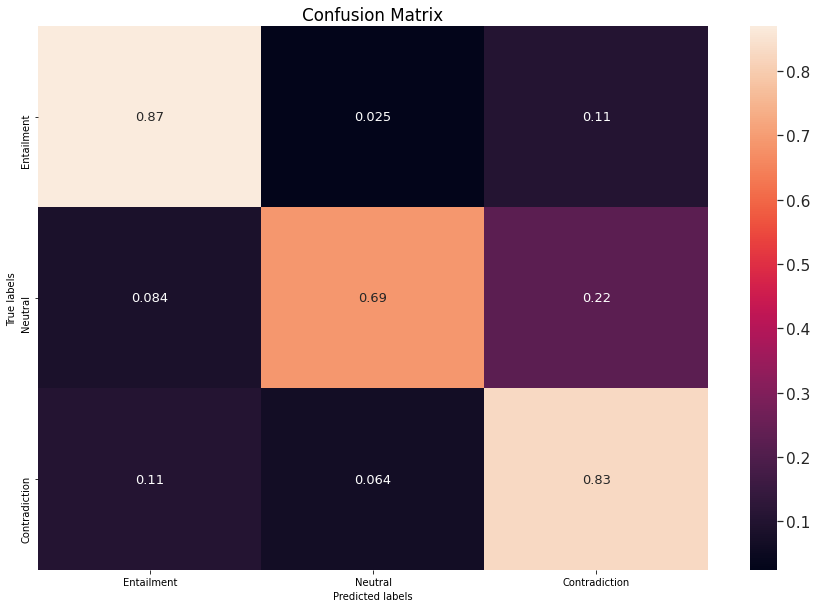

In [ ]:
pprint_confusion_matrix(confusion_matrix(test_dataset.labels, decoded_predicted_labels, normalize='true'))

### GDrive, Zip, TensorBoard

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!unzip "/content/drive/My Drive/7748_xlmr_model.zip" -d "/"

In [ ]:
!zip -r "/content/drive/My Drive/78_xlmr_model.zip" "/content/model/"

  adding: content/model/ (stored 0%)
  adding: content/model/XLM-R_Seq_CLS_optimizer_ckpt.pt (deflated 47%)
  adding: content/model/.ipynb_checkpoints/ (stored 0%)
  adding: content/model/XLM-R_Seq_CLS_model.pt (deflated 22%)
  adding: content/model/XLM-R_Seq_CLS_model.pth (deflated 22%)
  adding: content/model/predicted_labels.pkl (deflated 81%)
  adding: content/model/XLM-R_Seq_CLS_ckpt.pth (deflated 22%)


In [ ]:
!zip -r "/content/drive/My Drive/7748_xlmr_model_runs.zip" "/content/runs/"

In [ ]:
%load_ext tensorboard
%tensorboard --logdir runs